# Human Action Recognition using TensorFlow

This project is meant to serve as a diving board to developing real models using real data. 

Uses the Udemy course `TensorFlow Developer Certificate in 2023: Zero to Mastery` as a guideline. Will also use helper functions provided by that course as well.

Goal is to be within the top 10 results of the leaderboard provided at: https://aiplanet.com/challenges/233/data-sprint-76-human-activity-recognition-233/leaderboard/practice

## Check GPU

To access mixed precision training, we need to use a GPU that has a compute-capability of 7.0 or higher. A Nvidia T4 (7.5) would suffice in this instance.

Google Colab offers:
* K80 (Not compatible)
* P100 (Not compatible)
* Tesla T4 (compatible)

So, we need either a Tesla T4 (in Google Colab), or, if we're using our own hardware, our GPU needs a compute-score of 7.0+.

In [ ]:
# Essentially a game of chance if you get a Tesla T4 or not. To try again:
## Go to Runtime -> Factory Reset Runtime -> Yes. Then, re-run this cell.

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5294270b-a731-e3d2-be08-bac0b90d02d6)


## Get Helper Functions

In previous modules in the course, helper functions were created that assisted in small, repetitive tasks. We can import these functions to save on time.



In [ ]:
# Download helper functions script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-09 19:07:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-09 19:07:59 (83.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Let's import some helper functions

from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir


## Download the data

I'll be using a different dataset than the course-provided dataset (from TensorFlow Datasets). I'll be importing the datasets direct from the provided link: https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset.





In [ ]:
# Downloading the data
import pathlib
import tensorflow as tf

dataset_url = "https://dphi-live.s3.eu-west-1.amazonaws.com/dataset/Human+Action+Recognition-20220526T101201Z-001.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

332937529/332937529 [==============================] - 33s 0us/step


In [ ]:
print(data_dir)

/root/.keras/datasets/Human+Action+Recognition-20220526T101201Z-001


In [ ]:
walk_through_dir("/root/.keras/datasets/Human Action Recognition/")

There are 2 directories and 2 images in '/root/.keras/datasets/Human Action Recognition/'.
There are 0 directories and 5410 images in '/root/.keras/datasets/Human Action Recognition/test'.
There are 0 directories and 12601 images in '/root/.keras/datasets/Human Action Recognition/train'.


In [ ]:
# To ease development, I'll be sorted all images in the huge training dataset into their proper classes using some wacky i/o trickery
## Training_set.csv has all images and their respective labels, so I'll be using that as a basis

# Go through Training_set.csv and sort images into their respective classes

import pandas as pd

train_set_raw = pd.read_csv("/root/.keras/datasets/Human Action Recognition/Training_set.csv")

In [ ]:
train_set_raw.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [ ]:
# Get value counts for the classes

train_set_raw['label'].value_counts()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

In [ ]:
# Get class names

class_names = train_set_raw['label'].value_counts().index
print(class_names)

Index(['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
       'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
       'fighting', 'listening_to_music', 'running', 'texting'],
      dtype='object')


In [ ]:
## Testing!

#train_set_raw.loc[train_set_raw['label'] == 'sitting']['filename'].to_numpy()[0]

In [ ]:
# Create the appropriate directories for the training data

import os

if not os.path.exists('train'):
  os.makedirs('train') # Make the big train_set folder
if not os.path.exists('test'):
  os.makedirs('test')

for i in range(len(class_names)):
  tr_path = 'train/' + class_names[i]
  te_path = 'test/' + class_names[i]
  if not os.path.exists(tr_path):
    os.makedirs(tr_path)
  if not os.path.exists(te_path):
    os.makedirs(te_path)

In [ ]:
# Move (copy) files to the appropriate places

import shutil

for i in range(len(class_names)):
  current_class = class_names[i]
  tr_path = 'train/' + current_class + '/'
  te_path = 'test/' + current_class + '/'

  # Get all samples that have the current class
  current_images = train_set_raw.loc[train_set_raw['label'] == current_class]['filename'].to_numpy()

  for x in range(672): # 80% of 840 images allocated to training set
    #filepath = path + "/" + current_images[x]
    root_path = "/root/.keras/datasets/Human Action Recognition/train/" + current_images[x]
    shutil.copy(root_path, tr_path)
  
  for t in range(672, len(current_images)): # 20% of 840 images allocated to test set
    root_path = "/root/.keras/datasets/Human Action Recognition/train/" + current_images[t]
    shutil.copy(root_path, te_path)

In [ ]:
# Check directories
walk_through_dir("train/")

There are 15 directories and 0 images in 'train/'.
There are 0 directories and 672 images in 'train/texting'.
There are 0 directories and 672 images in 'train/laughing'.
There are 0 directories and 672 images in 'train/sleeping'.
There are 0 directories and 672 images in 'train/using_laptop'.
There are 0 directories and 672 images in 'train/sitting'.
There are 0 directories and 672 images in 'train/drinking'.
There are 0 directories and 672 images in 'train/dancing'.
There are 0 directories and 672 images in 'train/fighting'.
There are 0 directories and 672 images in 'train/calling'.
There are 0 directories and 672 images in 'train/listening_to_music'.
There are 0 directories and 672 images in 'train/eating'.
There are 0 directories and 672 images in 'train/hugging'.
There are 0 directories and 672 images in 'train/cycling'.
There are 0 directories and 672 images in 'train/clapping'.
There are 0 directories and 672 images in 'train/running'.


In [ ]:
walk_through_dir("test/")

There are 15 directories and 0 images in 'test/'.
There are 0 directories and 168 images in 'test/texting'.
There are 0 directories and 168 images in 'test/laughing'.
There are 0 directories and 168 images in 'test/sleeping'.
There are 0 directories and 168 images in 'test/using_laptop'.
There are 0 directories and 168 images in 'test/sitting'.
There are 0 directories and 168 images in 'test/drinking'.
There are 0 directories and 168 images in 'test/dancing'.
There are 0 directories and 168 images in 'test/fighting'.
There are 0 directories and 168 images in 'test/calling'.
There are 0 directories and 168 images in 'test/listening_to_music'.
There are 0 directories and 168 images in 'test/eating'.
There are 0 directories and 168 images in 'test/hugging'.
There are 0 directories and 168 images in 'test/cycling'.
There are 0 directories and 168 images in 'test/clapping'.
There are 0 directories and 168 images in 'test/running'.


### Explore Dataset

Some light exploration, just to confirm that the dataset's all downloaded good and just to get an idea of what it looks like.

We want to know:
  * Our class names -> see `class_names`
  * Shape of our input data -> will set to (224, 224)
  * Datatype of our input data
  * What do the labels look like (one-hot vs. label encoded) -> Generated automatically from image_datagen
  * Do the labels match with the class names? -> See above

In [ ]:
# Create function that plots random image from the directory

from PIL import Image
from random import randint
import matplotlib.pyplot as plt
import numpy as np

def plotRandom(classname):
  """
    Given a class and the specified size of the directory, plot a random image from the directory.
  """
  possible_images = train_set_raw.loc[train_set_raw['label'] == classname]['filename'].to_numpy() # Cheating a bit here
  choice = randint(0, len(possible_images) - 1)
  img_path = 'train/' + classname + '/' + possible_images[choice]
  img = np.asarray(Image.open(img_path))

  plt.imshow(img)

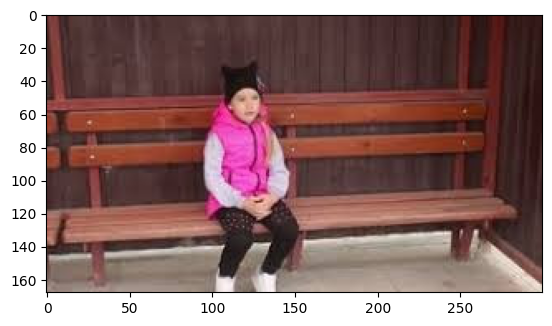

In [ ]:
plotRandom('sitting')

In [ ]:
# Putting our images in a tensorflow database
import tensorflow as tf

train_data = tf.keras.utils.image_dataset_from_directory('train/',
                                                                 label_mode='categorical',
                                                                 image_size=(224, 224))

test_data = tf.keras.utils.image_dataset_from_directory('test/',
                                                                 label_mode='categorical',
                                                                 image_size=(224, 224))

Found 10080 files belonging to 15 classes.
Found 2520 files belonging to 15 classes.


In [ ]:
# What is the type of our datagen?

type(train_data) # Batch dataset

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
# New class names -> Since our directories are in alphabetical order, so will our images labels

class_names = sorted(class_names)
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [ ]:
# Grab one sample of training data
# # It's initially a batch, so we have to convert to one sample

sample_one = train_data.take(1).unbatch().take(1) # As a batch, then unbatched, and yoink the first sample

In [ ]:
sample_one

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))>

In [ ]:
# Output some info about training sample

for image, label in sample_one:
  # Note, because our labels are one-hot encoded, I'll need to find the arg max of label and use that instead.
  #print(label)
  easy_label = tf.argmax(label).numpy()
  print(f"""
    Image Shape: {image.shape},
    Image Datatype: {image.dtype},
    Target Class from dataset (in tensor form): {label},
    Target Class from dataset (in not one-hot format): {easy_label}
    Class name (in string form): {class_names[easy_label]}
  """)


    Image Shape: (224, 224, 3),
    Image Datatype: <dtype: 'float32'>,
    Target Class from dataset (in tensor form): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.],
    Target Class from dataset (in not one-hot format): 8
    Class name (in string form): laughing
  


In [ ]:
image # A bunch of float 32s

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[  8.     ,   0.     ,   0.     ],
        [  8.     ,   0.     ,   0.     ],
        [  8.     ,   0.     ,   0.     ],
        ...,
        [  9.     ,   0.     ,   1.     ],
        [  9.     ,   0.     ,   1.     ],
        [  9.     ,   0.     ,   1.     ]],

       [[  8.     ,   0.     ,   0.     ],
        [  8.     ,   0.     ,   0.     ],
        [  8.     ,   0.     ,   0.     ],
        ...,
        [  9.     ,   0.     ,   1.     ],
        [  9.     ,   0.     ,   1.     ],
        [  9.     ,   0.     ,   1.     ]],

       [[  8.     ,   0.     ,   0.     ],
        [  8.     ,   0.     ,   0.     ],
        [  8.     ,   0.     ,   0.     ],
        ...,
        [  9.     ,   0.     ,   1.     ],
        [  9.     ,   0.     ,   1.     ],
        [  9.     ,   0.     ,   1.     ]],

       ...,

       [[186.     , 215.     , 247.     ],
        [187.4509 , 216.4509 , 248.4509 ],
        [189.62723, 218.627

In [ ]:
# Min and max values -> close 0 and 255 respectively

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [ ]:
# Plot an image from the dataset itself

def plotRandFromDataset(dataset):
  # Grab a random image from a random batch
  sample = dataset.take(1).unbatch().take(1)
  for image, label in sample:
    #print(label)
    #print(tf.math.argmax(label).numpy())
    #print(class_names)
    easy_label = class_names[tf.math.argmax(label).numpy()] # Get the class label of the image
    normalized_image = image.numpy() / 255.0 # Normalize values to [0, 1] to prevent any wacky errors
    plt.imshow(normalized_image) # plot the image
    plt.axis('off') # Turn off axis
    plt.title(f"Image of {easy_label}")
    plt.show()
  

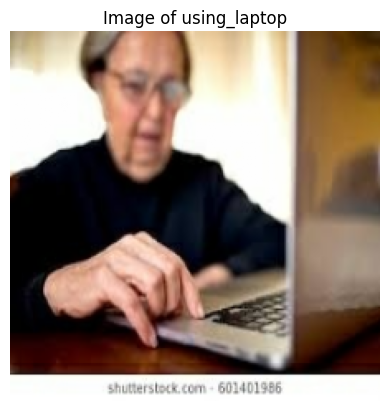

In [ ]:
# Dew it

plotRandFromDataset(train_data)

## Preparing Dataset

Our data's very ugly. Time to fix it up. Let's create a bunch of preprocessing functions to make it easy on us.

What we know about our data:
  * In dtype `float32`, which is fine
  * Contains 32 images per batch
  * All images are pushed into the (224, 224) image size because our datagen
  * Image values aren't normalized (between 0 and 255, not 0 and 1)

Models Like:
* Data in `float32` dtype
  * For mixed precision, `float16` and `float32`
* For batches, TensorFlow likes all tensors within a batch to be of the same size
* Likes normalized tensors (between 0 and 1)

With these points in mind, all we really need to do is scale our images (for both `ResNet50` and our CCT model below).

Additionally, if we want to throw some data augmentation into the mix, we'll need to do it here too. To that end, I propose that a data augmentation be created, with all the preprocessing layers we want.


In [ ]:
# cast our data to float32 if it hasn't already been done

def preprocess_img(image, label, img_shape=224):
  """
    Converts our image datatype to float32, and reshapes our image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
# Test out the above function

processed_img = preprocess_img(image, label)[0]
print(f"Before preprocessing: {image[:2]}\n Shape: {image.shape}\n Datatype:{image.dtype}")
print(f"After preprocessing: {processed_img[:2]}\n Shape: {processed_img.shape}\n Datatype:{processed_img.dtype}") # The exact same because it was already in the correct shape -> useful for new images!

Before preprocessing: [[[8. 0. 0.]
  [8. 0. 0.]
  [8. 0. 0.]
  ...
  [9. 0. 1.]
  [9. 0. 1.]
  [9. 0. 1.]]

 [[8. 0. 0.]
  [8. 0. 0.]
  [8. 0. 0.]
  ...
  [9. 0. 1.]
  [9. 0. 1.]
  [9. 0. 1.]]]
 Shape: (224, 224, 3)
 Datatype:<dtype: 'float32'>
After preprocessing: [[[8. 0. 0.]
  [8. 0. 0.]
  [8. 0. 0.]
  ...
  [9. 0. 1.]
  [9. 0. 1.]
  [9. 0. 1.]]

 [[8. 0. 0.]
  [8. 0. 0.]
  [8. 0. 0.]
  ...
  [9. 0. 1.]
  [9. 0. 1.]
  [9. 0. 1.]]]
 Shape: (224, 224, 3)
 Datatype:<dtype: 'float32'>


In [ ]:
# Creating our model
from tensorflow.keras import layers

data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.Rescaling(1.0/255.0) # Rescales images to 0 to 1
], name='data_augmentation')


### Optimize our pipeline

See: https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training (and parallelize)

#test_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

### Create Modelling Callbacks

We're going to create a couple of callbacks for our model:

* TensorBoard callback to log training results (to visualize our results)
* ModelCheckpoint callback to savour model's progress after feature extraction

Early stopping will be used for fine tuning

In [ ]:
# Create model callbacks!
## TensorBoard (have a function for this already), Model Checkpointing
checkpoint_path = 'model_checkpoints/cp.ckpt'

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   monitor='val_acc',
                                                   verbose=0)


### Setup Mixed Precision Training

First, here's the [official documentation](https://www.tensorflow.org/guide/mixed_precision).

Mixed precision utilizes a combination of float32 and float16 dtypes to speed up model performance.

In [ ]:
# turn on mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Creating Models

Because `EfficientNetB0` isn't really all that useful at the moment (as the tensorflow implementation can't really be saved easily) due to a bug, I'll be using two other models.

Why two models? Because I love to experiment and all that jazz.

I'll be using two models:
* ResNet50
* A Compact Convolutional Transformer (CCT)
  * Taken from the very smart people [here](https://keras.io/examples/vision/cct/). Big ups to Sayak Paul!

ResNet should do well regardless, but the CCT might complain about the low amount of images offered (relatively speaking). It'll be an interesting experiement anyway.

In [ ]:
!pip install keras-cv tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 27.8 MB/s eta 0:00:00


In [ ]:
!pip install keras-nlp --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.1/527.1 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 99.0 MB/s eta 0:00:00


In [ ]:
# import all the stuff

from tensorflow.keras import layers
from tensorflow import keras

import keras_cv as kcv
import keras_nlp as knlp

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [ ]:
# Creating the ResNet50 Model first -> Feature Extractor

tf.random.set_seed(2232)

# Download model and freeze layers

base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False

# Create the functional model

input_shape = (224, 224, 3)

inputs = layers.Input(shape=input_shape)
x = data_aug(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32)(x) # Need a float32 output layer for mixed precision to work properly
model = tf.keras.Model(inputs, outputs)

# Compile the model

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 15)                30735     
                                                                 
 activation (Activation)     (None, 15)                0     

In [ ]:
# Checking policies in model to ensure mixed precision use

for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
data_augmentation True float32 <Policy "float32">
resnet50 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation True float32 <Policy "float32">


* `layer.name`
  * The human readable name of a particular layer
* `layer.trainable`
  * Is the layer trainable or not?
  * If `False`, the weights are frozen
* `layer.dtype`
  * The data type a layer stores its variables in
* `layer.dtype_policy`
  * The data type policy a layer computes its variables on

Data aug, input layer, and the activation layer are all regular float32 policies.

However, the rest of the layers have a mixed float16 policy

In [ ]:
# What about the base model?

for layer in model.layers[2].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
conv1_pad False float32 <Policy "mixed_float16">
conv1_conv False float32 <Policy "mixed_float16">
conv1_bn False float32 <Policy "mixed_float16">
conv1_relu False float32 <Policy "mixed_float16">
pool1_pad False float32 <Policy "mixed_float16">
pool1_pool False float32 <Policy "mixed_float16">
conv2_block1_1_conv False float32 <Policy "mixed_float16">
conv2_block1_1_bn False float32 <Policy "mixed_float16">
conv2_block1_1_relu False float32 <Policy "mixed_float16">
conv2_block1_2_conv False float32 <Policy "mixed_float16">
conv2_block1_2_bn False float32 <Policy "mixed_float16">
conv2_block1_2_relu False float32 <Policy "mixed_float16">
conv2_block1_0_conv False float32 <Policy "mixed_float16">
conv2_block1_3_conv False float32 <Policy "mixed_float16">
conv2_block1_0_bn False float32 <Policy "mixed_float16">
conv2_block1_3_bn False float32 <Policy "mixed_float16">
conv2_block1_add False float32 <Policy "mixed_float16">
conv2_block1_out False fl

## Fit the Feature Extraction Model

* Fit our feature extraction model
* Later, we'll fine tune this model

In [ ]:
# Fit our model

tf.random.set_seed(2232)

fe_history = model.fit(train_data,
                       epochs=3,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=0.1 * len(test_data),
                       callbacks=[callback_ckpt, create_tensorboard_callback(dir_name='training_logs', experiment_name='resnetFE')])

Saving TensorBoard log files to: training_logs/resnetFE/20230504-191248
Epoch 1/3
315/315 [==============================] - ETA: 0s - loss: 2.7716 - accuracy: 0.0764

315/315 [==============================] - 195s 556ms/step - loss: 2.7716 - accuracy: 0.0764 - val_loss: 2.7498 - val_accuracy: 0.0391
Epoch 2/3
315/315 [==============================] - ETA: 0s - loss: 2.7502 - accuracy: 0.0817

315/315 [==============================] - 94s 296ms/step - loss: 2.7502 - accuracy: 0.0817 - val_loss: 2.7324 - val_accuracy: 0.0742
Epoch 3/3
315/315 [==============================] - ETA: 0s - loss: 2.7289 - accuracy: 0.0890

315/315 [==============================] - 77s 245ms/step - loss: 2.7289 - accuracy: 0.0890 - val_loss: 2.7502 - val_accuracy: 0.0859


WoohooO!

The above model has a validation accuracy of about 7.03% (the first time this cell was run). This score is above random guessing, which is \**checks notes*\* 6.66%.

Now, I just gotta figure out why my model's acting like a bunch of baloney.

A first step would be upping the learning rate and epochs and seeing if my model's being bottlenecked in some capacity.

In [ ]:
# Setting random seed

tf.random.set_seed(2232)

# Recompiling model

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

# Refitting the model with 5 epochs

fe_upped_history = model.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=0.1 * len(test_data),
                       callbacks=[callback_ckpt, create_tensorboard_callback(dir_name='training_logs', experiment_name='resnetFEUpped')])

Saving TensorBoard log files to: training_logs/resnetFEUpped/20230504-193530
Epoch 1/5
315/315 [==============================] - ETA: 0s - loss: 5.1308 - accuracy: 0.0704

315/315 [==============================] - 179s 444ms/step - loss: 5.1308 - accuracy: 0.0704 - val_loss: 5.0206 - val_accuracy: 0.0781
Epoch 2/5
315/315 [==============================] - ETA: 0s - loss: 5.3735 - accuracy: 0.0721

315/315 [==============================] - 91s 287ms/step - loss: 5.3735 - accuracy: 0.0721 - val_loss: 4.7149 - val_accuracy: 0.0820
Epoch 3/5
315/315 [==============================] - ETA: 0s - loss: 6.0607 - accuracy: 0.0835

315/315 [==============================] - 74s 234ms/step - loss: 6.0607 - accuracy: 0.0835 - val_loss: 4.0352 - val_accuracy: 0.0938
Epoch 4/5
315/315 [==============================] - ETA: 0s - loss: 5.2382 - accuracy: 0.0848

315/315 [==============================] - 70s 222ms/step - loss: 5.2382 - accuracy: 0.0848 - val_loss: 3.6361 - val_accuracy: 0.0820
Epoch 5/5
315/315 [==============================] - ETA: 0s - loss: 5.8341 - accuracy: 0.0808

315/315 [==============================] - 66s 207ms/step - loss: 5.8341 - accuracy: 0.0808 - val_loss: 3.7767 - val_accuracy: 0.0898


Started off promising, with 10% accuracy, but quickly dipped back down to 8%. Although it's better than before, it's still very, very, very suboptimal.

I could run this for another billion epochs or so to see if it really does improve over time or not, but that would take millenia. So, I'm going to try something different: fine-tuning.

In [ ]:
# Unfreeze 30 layers for fine-tuning

tf.random.set_seed(2232)

base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False

In [ ]:
# Recompile the model

tf.random.set_seed(2232)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# Fine tune for another 5 epochs -> See if it improves

ft_history = model.fit(train_data,
                       epochs=10,
                       steps_per_epoch=len(train_data),
                       initial_epoch=fe_upped_history.epoch[-1],
                       validation_data=test_data,
                       validation_steps=0.1 * len(test_data),
                       callbacks=[callback_ckpt, create_tensorboard_callback(dir_name='training_logs', experiment_name='resnetFT')])

Saving TensorBoard log files to: training_logs/resnetFT/20230504-194431
Epoch 5/10
315/315 [==============================] - ETA: 0s - loss: 4.7377 - accuracy: 0.0715

315/315 [==============================] - 85s 241ms/step - loss: 4.7377 - accuracy: 0.0715 - val_loss: 2.7029 - val_accuracy: 0.0820
Epoch 6/10
315/315 [==============================] - ETA: 0s - loss: 2.7160 - accuracy: 0.0813

315/315 [==============================] - 63s 200ms/step - loss: 2.7160 - accuracy: 0.0813 - val_loss: 2.7350 - val_accuracy: 0.0898
Epoch 7/10
315/315 [==============================] - ETA: 0s - loss: 2.6820 - accuracy: 0.0877

315/315 [==============================] - 64s 201ms/step - loss: 2.6820 - accuracy: 0.0877 - val_loss: 2.6376 - val_accuracy: 0.1211
Epoch 8/10
315/315 [==============================] - ETA: 0s - loss: 2.6466 - accuracy: 0.1011

315/315 [==============================] - 61s 194ms/step - loss: 2.6466 - accuracy: 0.1011 - val_loss: 2.6203 - val_accuracy: 0.1055
Epoch 9/10
315/315 [==============================] - ETA: 0s - loss: 2.6338 - accuracy: 0.1055

315/315 [==============================] - 59s 186ms/step - loss: 2.6338 - accuracy: 0.1055 - val_loss: 2.6097 - val_accuracy: 0.1250
Epoch 10/10
315/315 [==============================] - ETA: 0s - loss: 2.6271 - accuracy: 0.1096

315/315 [==============================] - 57s 178ms/step - loss: 2.6271 - accuracy: 0.1096 - val_loss: 2.6931 - val_accuracy: 0.1133


So, it's better. After ten epochs of long and ardous training, it's better... by only four percent (11.33% val-acc let's goo babbbyyyy!)

There has to be a better way than this, so I'm going to go under for a while and sniff around for better methods.

### Creating and Training CCT

I'm pretty much going to be straight up copying for now, just so I get a good idea of what this is actually all about.

In [ ]:
# Now, I'm going to construct the CCT based on the article given in the link above
## Hyperparameters and consts

positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim
]

transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32 # Because that's what my batches already are :)
num_epochs = 5 # For now
img_size = 224

num_classes = 15
input_shape = (224, 224, 3)


In [ ]:
# The tokenizer

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * tf.cast(random_tensor, tf.float16)
        return x

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(img_size, img_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [ ]:
def create_cct_model(
    image_size=img_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(img_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_data,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=test_data,
        validation_steps=0.1 * len(test_data),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_data)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history




In [ ]:
cct_model = create_cct_model()
history = run_experiment(cct_model)

At 27.74% accuracy, that's about the best results yet. Let's goooooo!

I'm going to do the same thing as above, but just set the epochs to 15 & increase the number of layers and stuff by 1.

In [ ]:

conv_layers = 3
num_heads = 3
transformer_layers = 3
num_epochs = 15 # For now



cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/15
315/315 [==============================] - 333s 985ms/step - loss: 2.6994 - accuracy: 0.1143 - top-5-accuracy: 0.4356 - val_loss: 2.5903 - val_accuracy: 0.1914 - val_top-5-accuracy: 0.5312
Epoch 2/15
315/315 [==============================] - 313s 992ms/step - loss: 2.5191 - accuracy: 0.1813 - top-5-accuracy: 0.5715 - val_loss: 2.4634 - val_accuracy: 0.2305 - val_top-5-accuracy: 0.5742
Epoch 3/15
315/315 [==============================] - 313s 993ms/step - loss: 2.4358 - accuracy: 0.2216 - top-5-accuracy: 0.6294 - val_loss: 2.4551 - val_accuracy: 0.2266 - val_top-5-accuracy: 0.6289
Epoch 4/15
315/315 [==============================] - 311s 987ms/step - loss: 2.3745 - accuracy: 0.2401 - top-5-accuracy: 0.6725 - val_loss: 2.3992 - val_accuracy: 0.2070 - val_top-5-accuracy: 0.6680
Epoch 5/15
315/315 [==============================] - 314s 997ms/step - loss: 2.3357 - accuracy: 0.2644 - top-5-accuracy: 0.6912 - val_loss: 2.3408 - val_accuracy: 0.3242 - val_top-5-accuracy: 0.6875


An hour and twenty minutes of training has yield a 35.87% test accuracy. This is slow progress, but progress all the same! I'll see if I'm able to speed it up somehow. For now, I'm going to manually download the model weights for later usage.

In [ ]:
cct_model.save_weights('cct')

In [ ]:
# h5 format

cct_model.save_weights('cct_weights.h5')